## Set Up

In [276]:
import pandas as pd
import calendar
import datetime

In [277]:
mta190504_raw = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_190504.txt")
mta190504_raw.describe()

,ENTRIES,EXITS
count,2.068570e+05,2.068570e+05
mean,4.057530e+07,3.319799e+07
std,2.082752e+08,1.926699e+08
min,0.000000e+00,0.000000e+00
25%,3.495460e+05,1.413340e+05
50%,2.176408e+06,1.241604e+06
75%,6.775342e+06,4.590174e+06
max,2.129343e+09,2.124127e+09


## Data Cleaning and Variable Creation

In [278]:
#Clean column names
mta190504_raw.columns = mta190504_raw.columns.str.strip()
mta190504_raw.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [279]:
# Go from raw DF to new DF that will have rows dropped
mta190504 = mta190504_raw.copy()

# Create variables:
# "time_hour" that simplifies the hour for later grouping purposes
mta190504["time_hour"] = pd.to_numeric(mta190504["TIME"].str[0:2])
# formatted date variable "DDATE"
mta190504['DDATE']=[datetime.datetime.strptime(x, '%m/%d/%Y') for x in mta190504['DATE']]
# formatted time variable "DTIME"
#mta190504['DTIME']=[format(datetime.datetime.strptime(x, '%H:%M:%S'),"%H:%M:%S") for x in mta190504['TIME']]
mta190504['DTIME']=[datetime.datetime.strptime(x, '%H:%M:%S') for x in mta190504['TIME']]
#mta190504['DTIME2'] = mta190504['DTIME'] - datetime.timedelta(seconds=1)
mta190504['DDATETIME'] = pd.to_datetime(mta190504['DATE']+" "+mta190504['TIME'])
mta190504['DDATETIME2'] = mta190504['DDATETIME'] - datetime.timedelta(seconds=1)
#mta190504['DTIME3'] = datetime.datetime.combine(mta190504['DDATE'],mta190504['DTIME'])
#mta190504['DTIME3'] = [datetime.datetime.combine(x,y) for x,y in [mta190504['DDATE'],mta190504['DTIME']]]
mta190504['DTIME']=[format(x,"%H:%M:%S") for x in mta190504['DTIME']]

# formatted day of the week variable "DDAY"
mta190504['DDAY']=[calendar.day_name[datetime.datetime.weekday(x)] for x in mta190504['DDATE']]
mta190504.head()
#mta190504.info()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,time_hour,DDATE,DTIME,DDATETIME,DDATETIME2,DDAY
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,00:00:00,REGULAR,7035249,2384833,0,2019-04-27,00:00:00,2019-04-27 00:00:00,2019-04-26 23:59:59,Saturday
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,04:00:00,REGULAR,7035269,2384840,4,2019-04-27,04:00:00,2019-04-27 04:00:00,2019-04-27 03:59:59,Saturday
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,08:00:00,REGULAR,7035292,2384875,8,2019-04-27,08:00:00,2019-04-27 08:00:00,2019-04-27 07:59:59,Saturday
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,12:00:00,REGULAR,7035392,2384951,12,2019-04-27,12:00:00,2019-04-27 12:00:00,2019-04-27 11:59:59,Saturday
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,16:00:00,REGULAR,7035651,2385020,16,2019-04-27,16:00:00,2019-04-27 16:00:00,2019-04-27 15:59:59,Saturday


In [280]:
# Sort before grouping
mta190504.sort_values(["C/A","UNIT","SCP","STATION","LINENAME","DIVISION","DATE","TIME","DESC"], inplace = True)
# Create difference columns to calculate difference in entries and exits between the row and the row before (aka the time before)
mta190504["entries_diff"] = mta190504.groupby(["C/A","UNIT","SCP","STATION","LINENAME","DIVISION"]).ENTRIES.diff()
mta190504["exits_diff"] = mta190504.groupby(["C/A","UNIT","SCP","STATION","LINENAME","DIVISION"]).EXITS.diff()
mta190504["entries-exits"] = mta190504["entries_diff"] - mta190504["exits_diff"]
mta190504["entries+exits"] = mta190504["entries_diff"] + mta190504["exits_diff"]
mta190504.describe()

,ENTRIES,EXITS,time_hour,entries_diff,exits_diff,entries-exits,entries+exits
count,2.068570e+05,2.068570e+05,206857.000000,2.020060e+05,2.020060e+05,2.020060e+05,2.020060e+05
mean,4.057530e+07,3.319799e+07,10.517256,2.075907e+03,7.433828e+03,-5.357922e+03,9.509735e+03
std,2.082752e+08,1.926699e+08,6.806081,3.508686e+06,3.415174e+06,1.754742e+06,6.698467e+06
min,0.000000e+00,0.000000e+00,0.000000,-8.392517e+08,-3.843496e+08,-6.714099e+08,-1.007094e+09
25%,3.495460e+05,1.413340e+05,4.000000,9.000000e+00,8.000000e+00,-2.500000e+01,2.700000e+01
50%,2.176408e+06,1.241604e+06,10.000000,7.200000e+01,5.200000e+01,1.000000e+00,1.680000e+02
75%,6.775342e+06,4.590174e+06,16.000000,2.390000e+02,1.660000e+02,9.700000e+01,4.550000e+02
max,2.129343e+09,2.124127e+09,23.000000,1.126553e+09,1.078346e+09,4.820644e+07,2.204899e+09


In [281]:
#keep only rows with positive entries_diff, exits_diff, and ENTRIES
mta190504= mta190504[mta190504.entries_diff > 0]
mta190504 = mta190504[mta190504.exits_diff > 0]
mta190504 = mta190504[mta190504.ENTRIES > 0]
# dropping turnstile 00-04-00 at 23rd st due to data anomaly
mta190504 = mta190504[(mta190504["STATION"] != "TWENTY THIRD ST") & (mta190504["SCP"] != "00-04-00")]
# exclude high entries and exits that are likely a result of a terminal reset
mta190504 = mta190504[mta190504.entries_diff < 10**7]
mta190504 = mta190504[mta190504.exits_diff < 10**7].reset_index().drop(["index"],axis=1)

mta190504.info()
mta190504.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165200 entries, 0 to 165199
Data columns (total 21 columns):
C/A              165200 non-null object
UNIT             165200 non-null object
SCP              165200 non-null object
STATION          165200 non-null object
LINENAME         165200 non-null object
DIVISION         165200 non-null object
DATE             165200 non-null object
TIME             165200 non-null object
DESC             165200 non-null object
ENTRIES          165200 non-null int64
EXITS            165200 non-null int64
time_hour        165200 non-null int64
DDATE            165200 non-null datetime64[ns]
DTIME            165200 non-null object
DDATETIME        165200 non-null datetime64[ns]
DDATETIME2       165200 non-null datetime64[ns]
DDAY             165200 non-null object
entries_diff     165200 non-null float64
exits_diff       165200 non-null float64
entries-exits    165200 non-null float64
entries+exits    165200 non-null float64
dtypes: datetime64[ns](3

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,...,time_hour,DDATE,DTIME,DDATETIME,DDATETIME2,DDAY,entries_diff,exits_diff,entries-exits,entries+exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,04:00:00,REGULAR,7035269,...,4,2019-04-27,04:00:00,2019-04-27 04:00:00,2019-04-27 03:59:59,Saturday,20.0,7.0,13.0,27.0
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,08:00:00,REGULAR,7035292,...,8,2019-04-27,08:00:00,2019-04-27 08:00:00,2019-04-27 07:59:59,Saturday,23.0,35.0,-12.0,58.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,12:00:00,REGULAR,7035392,...,12,2019-04-27,12:00:00,2019-04-27 12:00:00,2019-04-27 11:59:59,Saturday,100.0,76.0,24.0,176.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,16:00:00,REGULAR,7035651,...,16,2019-04-27,16:00:00,2019-04-27 16:00:00,2019-04-27 15:59:59,Saturday,259.0,69.0,190.0,328.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,20:00:00,REGULAR,7035930,...,20,2019-04-27,20:00:00,2019-04-27 20:00:00,2019-04-27 19:59:59,Saturday,279.0,50.0,229.0,329.0
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/28/2019,00:00:00,REGULAR,7036100,...,0,2019-04-28,00:00:00,2019-04-28 00:00:00,2019-04-27 23:59:59,Sunday,170.0,17.0,153.0,187.0
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/28/2019,04:00:00,REGULAR,7036119,...,4,2019-04-28,04:00:00,2019-04-28 04:00:00,2019-04-28 03:59:59,Sunday,19.0,1.0,18.0,20.0
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/28/2019,08:00:00,REGULAR,7036125,...,8,2019-04-28,08:00:00,2019-04-28 08:00:00,2019-04-28 07:59:59,Sunday,6.0,15.0,-9.0,21.0
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/28/2019,12:00:00,REGULAR,7036197,...,12,2019-04-28,12:00:00,2019-04-28 12:00:00,2019-04-28 11:59:59,Sunday,72.0,52.0,20.0,124.0
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/28/2019,16:00:00,REGULAR,7036372,...,16,2019-04-28,16:00:00,2019-04-28 16:00:00,2019-04-28 15:59:59,Sunday,175.0,43.0,132.0,218.0


In [282]:
# Checks
# No negative values in entries_diff or exits_diff
mta190504.describe()

,ENTRIES,EXITS,time_hour,entries_diff,exits_diff,entries-exits,entries+exits
count,1.652000e+05,1.652000e+05,165200.000000,165200.000000,165200.000000,165200.000000,165200.000000
mean,2.704001e+07,2.009741e+07,10.910363,211.283844,163.902282,47.381562,375.186126
std,1.588596e+08,1.345050e+08,6.713082,265.142739,245.083668,316.553500,400.658501
min,2.000000e+00,9.000000e+00,0.000000,1.000000,1.000000,-4327.000000,2.000000
25%,6.896625e+05,3.837185e+05,5.000000,31.000000,24.000000,-40.000000,82.000000
50%,2.830340e+06,1.661246e+06,12.000000,116.000000,78.000000,12.000000,246.000000
75%,7.047870e+06,5.032832e+06,17.000000,290.000000,202.000000,134.000000,533.000000
max,2.115816e+09,2.037805e+09,23.000000,6371.000000,4406.000000,6345.000000,6397.000000


In [283]:
#create intervals: 01-04;05-08;09-12;13-16;17-20;21-00
#start with 01 instead of 00, assuming that most audits are on the hour so first element is inclusive
#and last element is exclusive
def time_interval(x):
#     if x in [1,2,3,4]:
#         return "01:00-04:59"
#     elif x in [5,6,7,8]:
#         return "05:00-08:59"
#     elif x in [9,10,11,12]:
#         return "09:00-12:59"
#     elif x in [13,14,15,16]:
#         return "13:00-16:59"
#     elif x in [17,18,19,20]:
#         return "17:00-20:59"
#     elif x in [21,22,23,0]:
#         return "21:00-00:59"
    if x in [0,1,2,3]:
        return "0:00-03:59"
    elif x in [4,5,6,7]:
        return "04:00-07:59"
    elif x in [8,9,10,11]:
        return "08:00-11:59"
    elif x in [12,13,14,15]:
        return "12:00-15:59"
    elif x in [16,17,18,19]:
        return "16:00-19:59"
    elif x in [20,21,22,23]:
        return "20:00-23:59"

In [284]:
# create time period category "time_cat"
mta190504["time_cat"] = mta190504["time_hour"].apply(time_interval)
mta190504.head(50)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,...,DDATE,DTIME,DDATETIME,DDATETIME2,DDAY,entries_diff,exits_diff,entries-exits,entries+exits,time_cat
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,04:00:00,REGULAR,7035269,...,2019-04-27,04:00:00,2019-04-27 04:00:00,2019-04-27 03:59:59,Saturday,20.0,7.0,13.0,27.0,04:00-07:59
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,08:00:00,REGULAR,7035292,...,2019-04-27,08:00:00,2019-04-27 08:00:00,2019-04-27 07:59:59,Saturday,23.0,35.0,-12.0,58.0,08:00-11:59
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,12:00:00,REGULAR,7035392,...,2019-04-27,12:00:00,2019-04-27 12:00:00,2019-04-27 11:59:59,Saturday,100.0,76.0,24.0,176.0,12:00-15:59
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,16:00:00,REGULAR,7035651,...,2019-04-27,16:00:00,2019-04-27 16:00:00,2019-04-27 15:59:59,Saturday,259.0,69.0,190.0,328.0,16:00-19:59
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,20:00:00,REGULAR,7035930,...,2019-04-27,20:00:00,2019-04-27 20:00:00,2019-04-27 19:59:59,Saturday,279.0,50.0,229.0,329.0,20:00-23:59
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/28/2019,00:00:00,REGULAR,7036100,...,2019-04-28,00:00:00,2019-04-28 00:00:00,2019-04-27 23:59:59,Sunday,170.0,17.0,153.0,187.0,0:00-03:59
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/28/2019,04:00:00,REGULAR,7036119,...,2019-04-28,04:00:00,2019-04-28 04:00:00,2019-04-28 03:59:59,Sunday,19.0,1.0,18.0,20.0,04:00-07:59
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/28/2019,08:00:00,REGULAR,7036125,...,2019-04-28,08:00:00,2019-04-28 08:00:00,2019-04-28 07:59:59,Sunday,6.0,15.0,-9.0,21.0,08:00-11:59
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/28/2019,12:00:00,REGULAR,7036197,...,2019-04-28,12:00:00,2019-04-28 12:00:00,2019-04-28 11:59:59,Sunday,72.0,52.0,20.0,124.0,12:00-15:59
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/28/2019,16:00:00,REGULAR,7036372,...,2019-04-28,16:00:00,2019-04-28 16:00:00,2019-04-28 15:59:59,Sunday,175.0,43.0,132.0,218.0,16:00-19:59


In [285]:
# For outlier entries and exit differences, replace with imputed mean for the remaining valid entries
# INSERT SHREYAK'S CODE

## Output grouped data

In [286]:
# Group by station
mta_station = mta190504.groupby(["STATION"])[["entries_diff","exits_diff","entries+exits"]].sum().sort_values(["entries+exits","entries_diff","exits_diff"], ascending=False)
mta_station.head(5)

,entries_diff,exits_diff,entries+exits
STATION,,,
34 ST-PENN STA,1023199.0,922432.0,1945631.0
GRD CNTRL-42 ST,881117.0,769767.0,1650884.0
34 ST-HERALD SQ,703365.0,661376.0,1364741.0
14 ST-UNION SQ,650999.0,613366.0,1264365.0
TIMES SQ-42 ST,614463.0,579138.0,1193601.0


In [287]:
# Group by station and date
mta_station_date = mta190504.groupby(["STATION","DDATE"])[["entries_diff","exits_diff","entries+exits"]].sum().sort_values(["entries+exits","entries_diff","exits_diff"], ascending=False)

## Graph 1

In [288]:
# Group by station and day of week
mta_station_day = mta190504.groupby(["STATION","DATE","DDAY"], as_index=False)[["entries_diff","exits_diff","entries+exits","entries-exits"]].sum().sort_values(["STATION","entries+exits"], ascending=False)
#mta_station_day

In [289]:
# output for graph 1
mta_station_dayavg = mta_station_day.groupby(["STATION"], as_index=False)[["entries+exits"]].mean()
mta_station_dayavg.sort_values("entries+exits", inplace = True)
mta_station_dayavg.head(10)


,STATION,entries+exits
342,ST. GEORGE,212.250000
161,BROAD CHANNEL,330.000000
140,BEACH 105 ST,390.428571
147,BEACH 98 ST,807.142857
331,ROCKAWAY PARK B,1224.428571
146,BEACH 90 ST,1258.571429
121,AQUEDUCT RACETR,1344.714286
143,BEACH 44 ST,1382.285714
291,NEPTUNE AV,1690.000000
142,BEACH 36 ST,1770.142857


In [290]:
# Group by station, day of week, and time of day
#mta_station_day_time = mta190504.groupby(["STATION","DDAY","time_cat"])[["entries_diff","exits_diff","entries+exits"]].sum().sort_values(["entries+exits","entries_diff","exits_diff"], ascending=False)
#mta_station_day_time

In [291]:
# Group by station, day of week, and time of day
#mta_station_day_time = mta190504.groupby(["STATION","DDAY","time_cat"])[["entries_diff","exits_diff","entries+exits"]].sum().sort_values(["STATION","DDAY","time_cat"], ascending=False)
#mta_station_day_time[mta_station_day_time["STATION"] == "34 ST-PENN STA"]

In [292]:
import matplotlib.pyplot as plt
# You can configure the format of the images: ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’.
%config InlineBackend.figure_format = 'svg'
# this statement allows the visuals to render within your Jupyter Notebook
%matplotlib inline 

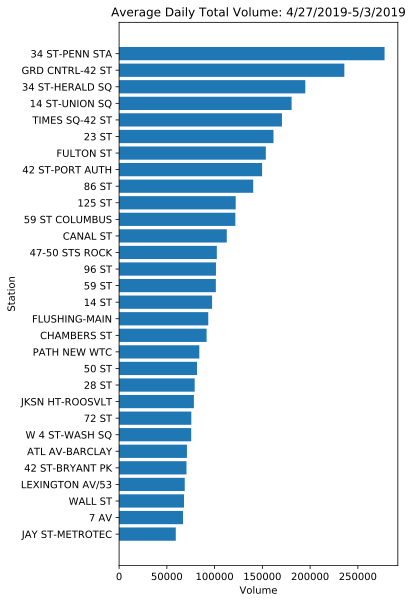

In [293]:
#Plot graph of total volume
plt.figure(figsize = [5,10])
plt.barh(mta_station_dayavg["STATION"][-30:],mta_station_dayavg["entries+exits"][-30:])
plt.title("Average Daily Total Volume: 4/27/2019-5/3/2019")
plt.ylabel("Station")
plt.xlabel("Volume");

## Graph 2

In [294]:
mta_station_time = mta190504.groupby(["STATION","DATE","DDAY","time_cat"], as_index=False)[["entries_diff","exits_diff","entries+exits","entries-exits"]].sum().sort_values(["STATION","DDAY","time_cat"])
mta_station_time.head(10)
mta_station_timeavg = mta_station_time.groupby(["STATION","time_cat"],as_index=False)[["entries-exits"]].mean()
mta_station_timeavg.head(10)

,STATION,time_cat,entries-exits
0,1 AV,04:00-07:59,50.571429
1,1 AV,08:00-11:59,-917.571429
2,1 AV,0:00-03:59,-59.000000
3,1 AV,12:00-15:59,-1104.428571
4,1 AV,16:00-19:59,229.428571
5,1 AV,20:00-23:59,-282.571429
6,103 ST,04:00-07:59,-197.142857
7,103 ST,08:00-11:59,3235.000000
8,103 ST,0:00-03:59,-639.000000
9,103 ST,12:00-15:59,3121.285714


In [296]:
#Graph 
mta_station_day_time = mta190504.groupby(["STATION","DDAY","time_cat"])[["entries_diff","exits_diff","entries+exits"]].sum().sort_values(["STATION","DDAY","time_cat"], ascending=False)
mta_station_day_time.head(20)

entries_diff  exits_diff  entries+exits
STATION   DDAY      time_cat                                            
ZEREGA AV Wednesday 20:00-23:59         332.0       853.0         1185.0
                    16:00-19:59         607.0       653.0         1260.0
                    12:00-15:59         545.0       314.0          859.0
                    0:00-03:59           81.0       286.0          367.0
                    08:00-11:59        1274.0       532.0         1806.0
                    04:00-07:59          61.0        62.0          123.0
          Tuesday   20:00-23:59         348.0       807.0         1155.0
                    16:00-19:59         589.0       574.0         1163.0
                    12:00-15:59         525.0       305.0          830.0
                    0:00-03:59           62.0       289.0          351.0
                    08:00-11:59        1227.0       503.0         1730.0
                    04:00-07:59          60.0        63.0          123.0
          Thursday  20:00-23:59         379.0       817.0         1196.0
                    16:00-19:59         600.0       615.0         1215.0
                    12:00-15:59         540.0       345.0          885.0
                    0:00-03:59           72.0       257.0          329.0
                    08:00-11:59        1264.0       481.0         1745.0
                    04:00-07:59          62.0        67.0          129.0
          Sunday    20:00-23:59         136.0       261.0          397.0
                    16:00-19:59         253.0       246.0          499.0